In [12]:
import pandas as pd
df = pd.read_csv('/content/merged_streaming_dataset.csv')
print("Shape of the DataFrame:", df.shape)
print("\nFirst 5 rows of the DataFrame:")
print(df.head())
print("\nDataFrame Info:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())

Shape of the DataFrame: (22997, 11)

First 5 rows of the DataFrame:
                   title         director  \
0   Dick Johnson Is Dead  Kirsten Johnson   
1          Blood & Water              NaN   
2              Ganglands  Julien Leclercq   
3  Jailbirds New Orleans              NaN   
4           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   
3  Sep

## Clean Data



In [13]:
import pandas as pd
df = pd.read_csv('/content/merged_streaming_dataset.csv')
print("Original shape:", df.shape)
for col in df.select_dtypes(include='object').columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace('nan', pd.NA)
df.drop_duplicates(inplace=True)
print("Shape after dropping duplicates:", df.shape)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled missing values in numeric column '{col}' with median: {median_val}")
categorical_cols = [col for col in df.select_dtypes(include='object').columns if col not in ['title', 'description']]
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Filled missing values in categorical column '{col}' with mode: {mode_val}")
if df['description'].isnull().any():
    df['description'] = df['description'].fillna('')
    print("Filled missing values in 'description' column with empty string.")
print("\nMissing values after cleaning:")
print(df.isnull().sum())
print("\nData cleaning complete.")

Original shape: (22997, 11)
Shape after dropping duplicates: (22997, 11)
Filled missing values in categorical column 'director' with mode: Mark Knight
Filled missing values in categorical column 'cast' with mode: Maggie Binkley
Filled missing values in categorical column 'country' with mode: United States
Filled missing values in categorical column 'date_added' with mode: November 12, 2019
Filled missing values in categorical column 'rating' with mode: TV-MA
Filled missing values in categorical column 'duration' with mode: 1 Season
Filled missing values in 'description' column with empty string.

Missing values after cleaning:
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
platform        0
dtype: int64

Data cleaning complete.


## Feature Engineering


In [14]:
import numpy as np
import pandas as pd
df = pd.read_csv('/content/merged_streaming_dataset.csv')
for col in df.select_dtypes(include='object').columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].replace('nan', pd.NA)
df.drop_duplicates(inplace=True)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
categorical_cols = [col for col in df.select_dtypes(include='object').columns if col not in ['title', 'description']]
for col in categorical_cols:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
if df['description'].isnull().any():
    df['description'] = df['description'].fillna('')
df['content_type'] = np.where(
    df['duration'].str.contains('Season', case=False, na=False),
    'TV Show',
    'Movie'
)
df['main_genre'] = df['listed_in'].apply(lambda x: x.split(',')[0].strip())
df['duration_minutes'] = np.nan
movie_mask = (df['content_type'] == 'Movie')
extracted_movie_durations = df.loc[movie_mask, 'duration'].str.extract(r'(\d+)', expand=False)
df.loc[movie_mask, 'duration_minutes'] = pd.to_numeric(extracted_movie_durations, errors='coerce')
df['description_length'] = df['description'].str.len()
median_movie_duration = df.loc[movie_mask, 'duration_minutes'].median()
df['duration_minutes'] = df['duration_minutes'].fillna(median_movie_duration)
print(f"Median movie duration used for filling: {median_movie_duration}")
columns_to_drop = [
    'title', 'director', 'cast', 'country', 'date_added',
    'duration', 'listed_in', 'description'
]
df.drop(columns=columns_to_drop, inplace=True)
categorical_cols_ohe = ['rating', 'platform', 'main_genre', 'content_type']
df_encoded = pd.get_dummies(df, columns=categorical_cols_ohe, drop_first=True, dtype=int)
df = df_encoded
print("\nFirst 5 rows of the DataFrame after feature engineering and encoding:")
print(df.head())
print("\nShape of the DataFrame after feature engineering and encoding:", df.shape)

Median movie duration used for filling: 94.0

First 5 rows of the DataFrame after feature engineering and encoding:
   release_year  duration_minutes  description_length  rating_100 min  \
0          2020              90.0                 152               0   
1          2021              94.0                 147               0   
2          2021              94.0                 146               0   
3          2021              94.0                 147               0   
4          2021              94.0                 152               0   

   rating_101 min  rating_102 min  rating_103 min  rating_104 min  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   rating_105 min  rating_106 

## Train-Test Split



In [15]:
from sklearn.model_selection import train_test_split
target_variable = 'content_type_TV Show'
X = df.drop(columns=[target_variable])
y = df[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (18397, 205)
Shape of X_test: (4600, 205)
Shape of y_train: (18397,)
Shape of y_test: (4600,)


## Train Classification Models




In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
scaler = StandardScaler()
pipeline_lr = Pipeline([
    ('scaler', scaler),
    ('logistic_regression', LogisticRegression(random_state=42, solver='liblinear'))
])
pipeline_rf = Pipeline([
    ('random_forest', RandomForestClassifier(random_state=42))
])
pipeline_xgb = Pipeline([
    ('xgboost', XGBClassifier(eval_metric='logloss', random_state=42))
])
print("Training Logistic Regression model...")
pipeline_lr.fit(X_train, y_train)
print("Logistic Regression model trained.")
print("\nTraining Random Forest model...")
pipeline_rf.fit(X_train, y_train)
print("Random Forest model trained.")
print("\nTraining XGBoost model...")
pipeline_xgb.fit(X_train, y_train)
print("XGBoost model trained.")

Training Logistic Regression model...
Logistic Regression model trained.

Training Random Forest model...
Random Forest model trained.

Training XGBoost model...
XGBoost model trained.


## Evaluate Models





--- Evaluating Logistic Regression ---
Accuracy: 0.9298
Precision: 0.9178
Recall: 0.8450
F1-Score: 0.8799


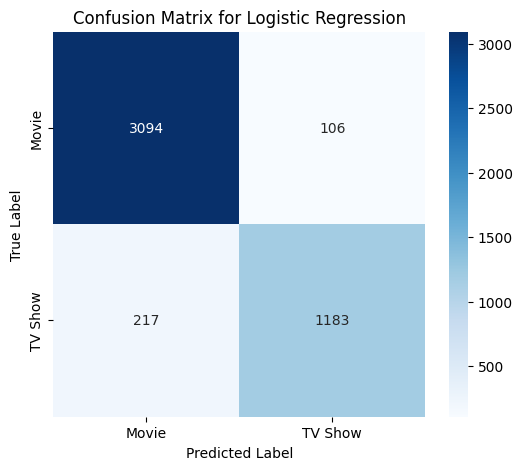


--- Evaluating Random Forest ---
Accuracy: 0.9935
Precision: 0.9858
Recall: 0.9929
F1-Score: 0.9893


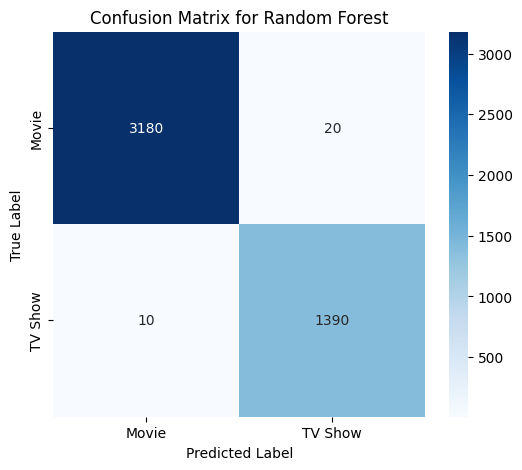


--- Evaluating XGBoost ---
Accuracy: 0.9937
Precision: 0.9831
Recall: 0.9964
F1-Score: 0.9897


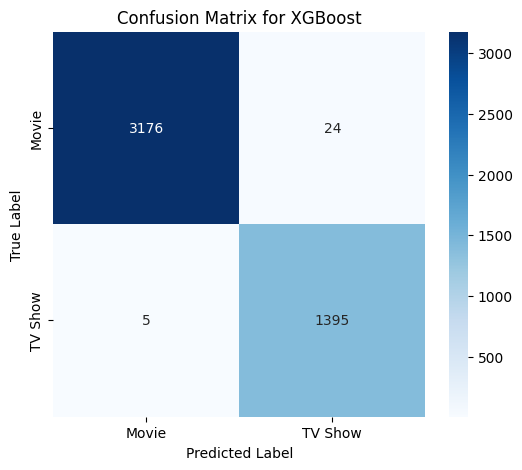


--- Best Performing Model ---
The best performing model based on F1-Score is: XGBoost with F1-Score: 0.9897


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
models = {
    "Logistic Regression": pipeline_lr,
    "Random Forest": pipeline_rf,
    "XGBoost": pipeline_xgb
}
best_model_name = ""
best_f1_score = -1
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_name = name
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Movie', 'TV Show'], yticklabels=['Movie', 'TV Show'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
print(f"\n--- Best Performing Model ---")
print(f"The best performing model based on F1-Score is: {best_model_name} with F1-Score: {best_f1_score:.4f}")

## Plot Results




Top 20 Feature Importances for XGBoost Model:
                               feature  importance
1                     duration_minutes    0.785042
96                            rating_R    0.024313
131                main_genre_Comedies    0.021757
95                        rating_PG-13    0.020161
144                  main_genre_Dramas    0.018762
110      main_genre_Action & Adventure    0.013826
94                           rating_PG    0.011819
140           main_genre_Documentaries    0.008129
154                  main_genre_Horror    0.006406
108                      platform_Hulu    0.006401
32                          rating_18+    0.006166
89                            rating_G    0.006136
97                        rating_TV-14    0.005643
31                          rating_16+    0.005413
159  main_genre_International TV Shows    0.004360
196                main_genre_TV Shows    0.004309
161                main_genre_Kids' TV    0.003563
103                       rating_TV-

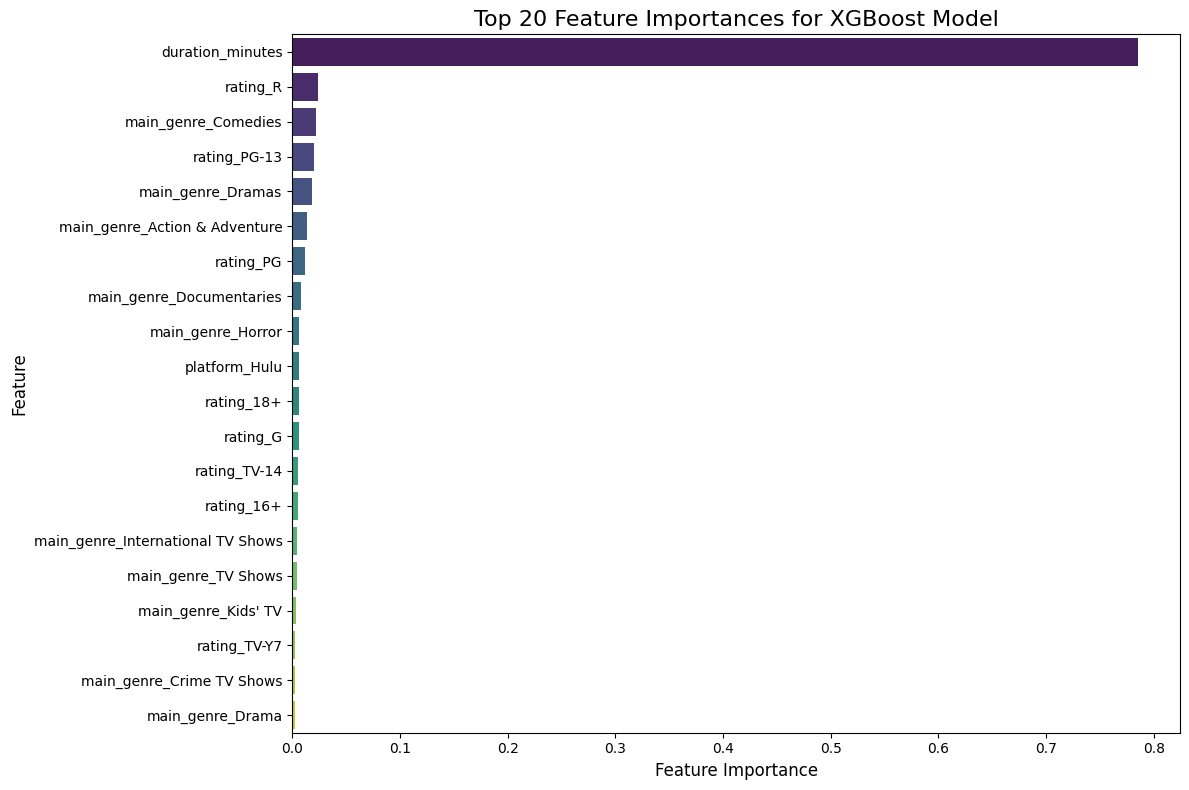

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
xgb_model = pipeline_xgb.named_steps['xgboost']
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})
top_n = 20
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(top_n)
print(f"Top {top_n} Feature Importances for XGBoost Model:")
print(top_features)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis', hue='feature', legend=False)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

Top 20 Feature Importances for XGBoost Model:
                               feature  importance
1                     duration_minutes    0.785042
96                            rating_R    0.024313
131                main_genre_Comedies    0.021757
95                        rating_PG-13    0.020161
144                  main_genre_Dramas    0.018762
110      main_genre_Action & Adventure    0.013826
94                           rating_PG    0.011819
140           main_genre_Documentaries    0.008129
154                  main_genre_Horror    0.006406
108                      platform_Hulu    0.006401
32                          rating_18+    0.006166
89                            rating_G    0.006136
97                        rating_TV-14    0.005643
31                          rating_16+    0.005413
159  main_genre_International TV Shows    0.004360
196                main_genre_TV Shows    0.004309
161                main_genre_Kids' TV    0.003563
103                       rating_TV-

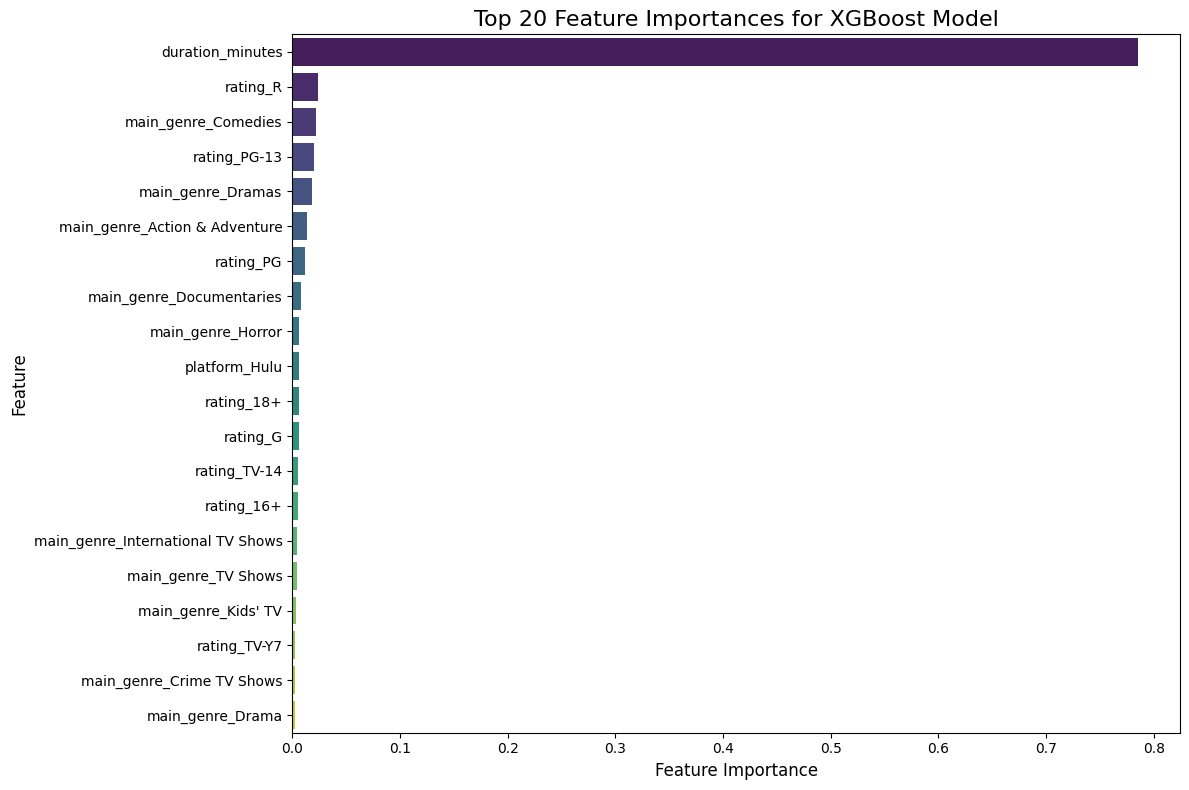

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
xgb_model = pipeline_xgb.named_steps['xgboost']
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})
top_n = 20
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(top_n)
print(f"Top {top_n} Feature Importances for XGBoost Model:")
print(top_features)
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis', hue='feature', legend=False)
plt.title(f'Top {top_n} Feature Importances for XGBoost Model', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## Cross-Validation



In [10]:
from sklearn.model_selection import cross_val_score
best_model_pipeline = models[best_model_name]
cv_scores = cross_val_score(best_model_pipeline, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores for {best_model_name}: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of CV accuracy: {cv_scores.std():.4f}")


Cross-validation scores for XGBoost: [0.9976087  0.99565217 0.99086758 0.98782344 0.98021309]
Mean CV accuracy: 0.9904
Standard deviation of CV accuracy: 0.0062


## Save Model


In [11]:
import joblib
model_filename = 'best_classification_model.joblib'
joblib.dump(best_model_pipeline, model_filename)
print(f"Best model saved successfully to {model_filename}")

Best model saved successfully to best_classification_model.joblib
